In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
%matplotlib inline

In [147]:
# Load dataset
data = pd.read_csv('./dataset/income.csv')

## CSI 4106 Introduction to Artificial Intelligence
#### PROJECT 1 Classification Empirical Study
Ara Kirijian 300062347 <br />
Austin Fan 300018056 <br />
<small>November 1, 2022</small>  

### 1. Our Dataset
The goal of this dataset is to determine if an individual has an income greater then fifty-thousand dollars. As such it is a binary classification task. There are niche applications for such a model, such as determining if someone is in need of financial aid. We selected it because it has a good number of comprehensive features, a large number of training examples and a mix of continuous and discrete features.


### 2. Data Analysis

This is a dataset of 32,561 training examples, it has 13 features: 
- `age` - continuous
- `workclass` - discrete
- `education` - discrete
- `education-num` - continuous
- `marital-status` - discrete
- `occupation` - discrete
- `relationship` - discrete
- `race` - discrete
- `sex` - discrete
- `capital-gain` - continuous
- `capital-loss` - continuous
- `hours-per-week` - continuous
- `native-country` - discrete

Our target variable is `income >50k` which is a binary variable.

In total there are 5 continuous features and 8 discrete features. However, since `education` and `education-num` are the same feature simply encoded differently, we really have 4 continuous features. There is some missing data in the `workclass`, `occupation` and `native-country` features. We will deal with this in the following section. It is also worth noting that the dataset is quite imbalanced, with only 24% of the training examples having an income greater than 50k. This will be important to keep in mind when we evaluate our models.

In [148]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,66,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [149]:
data.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income >50K          0
dtype: int64

##### Feature Distribution

In [150]:
## Start by splitting the data into our continuous and discrete features
continuous_features = [v for v in data.columns if data[v].dtype != 'object']
discrete_features = [v for v in data.columns if data[v].dtype == 'object']

C:\Users\arahu\AppData\Local\Temp\ipykernel_20036\1746966942.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_20036\1746966942.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_2003

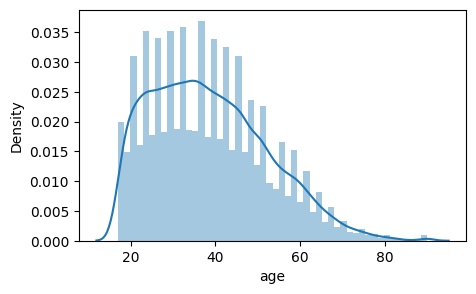

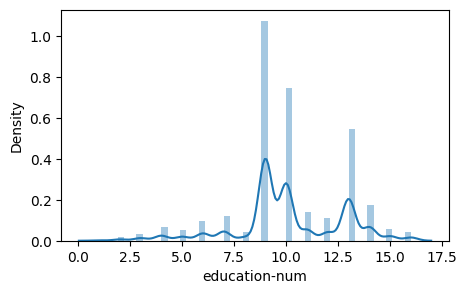

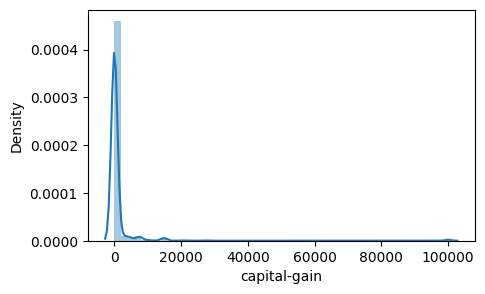

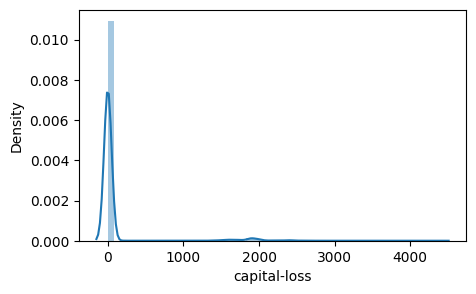

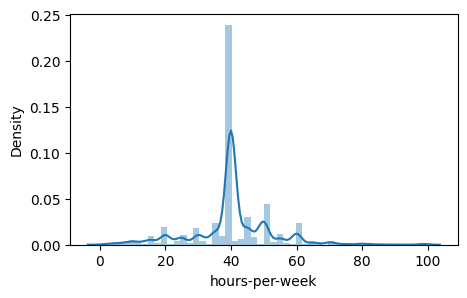

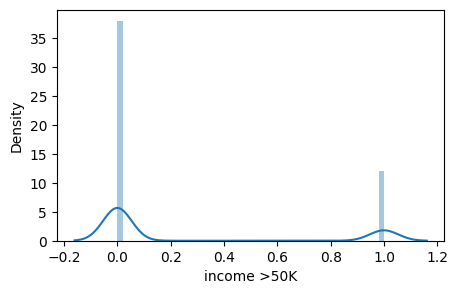

In [151]:
## Start with the continuous features
for col in continuous_features:
    plt.figure(figsize=(5, 3))
    sns.distplot(data[col])

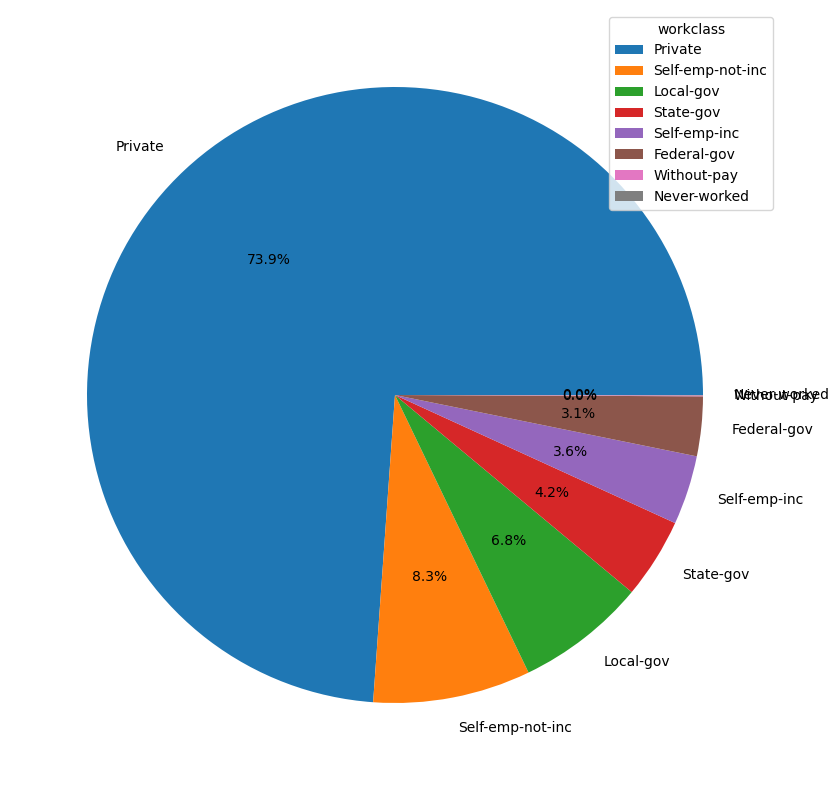

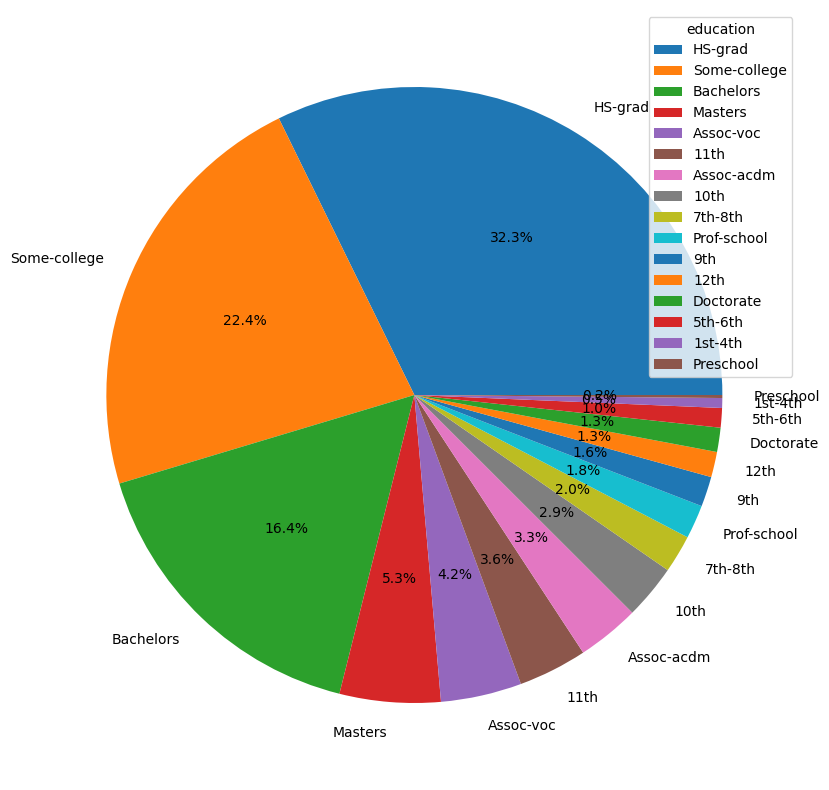

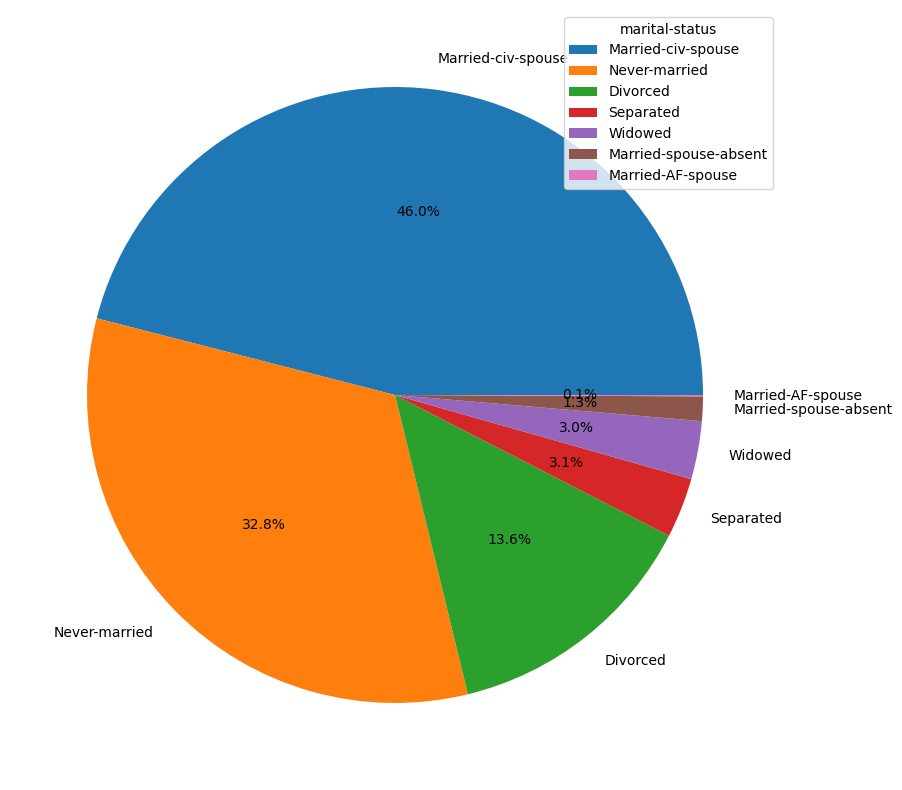

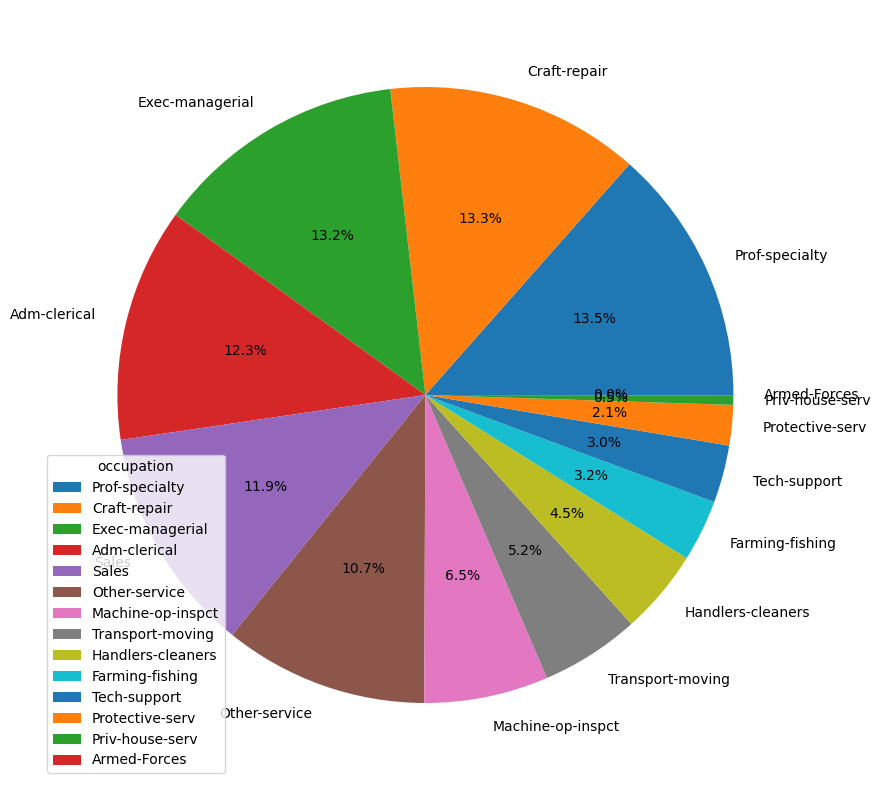

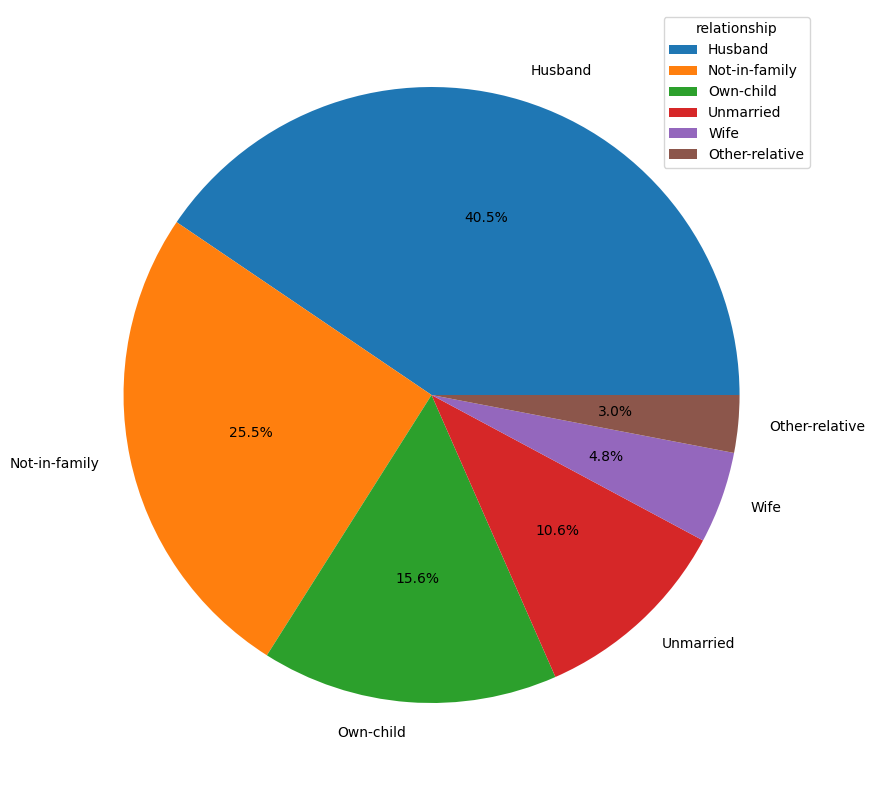

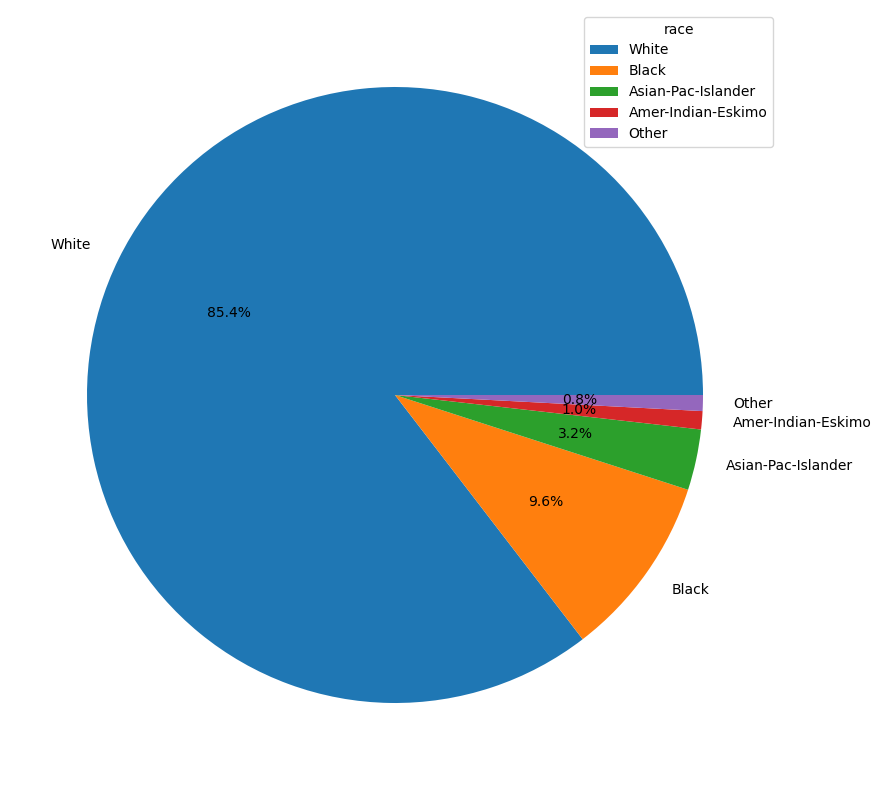

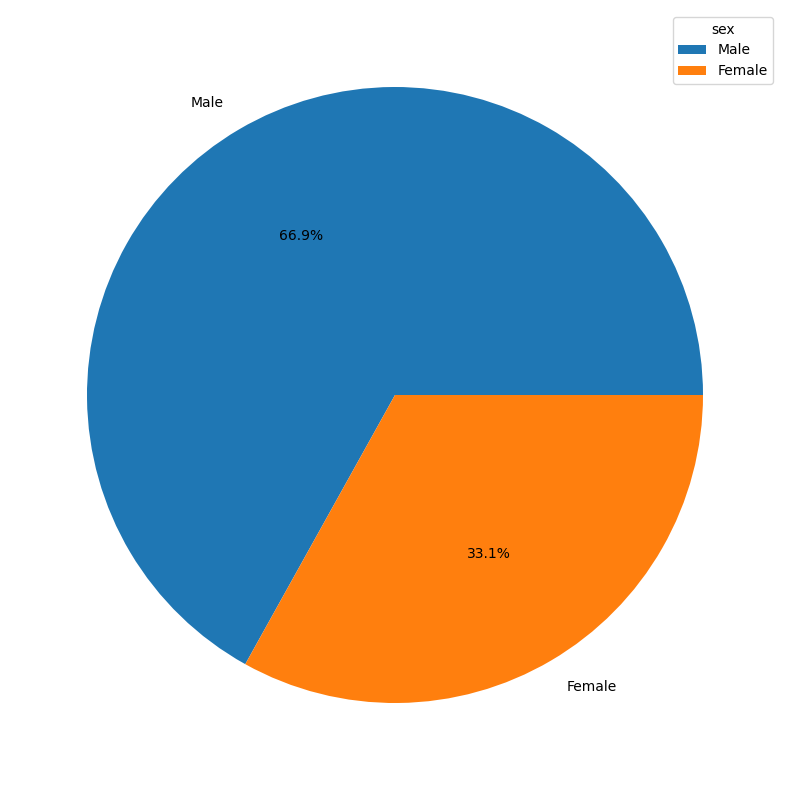

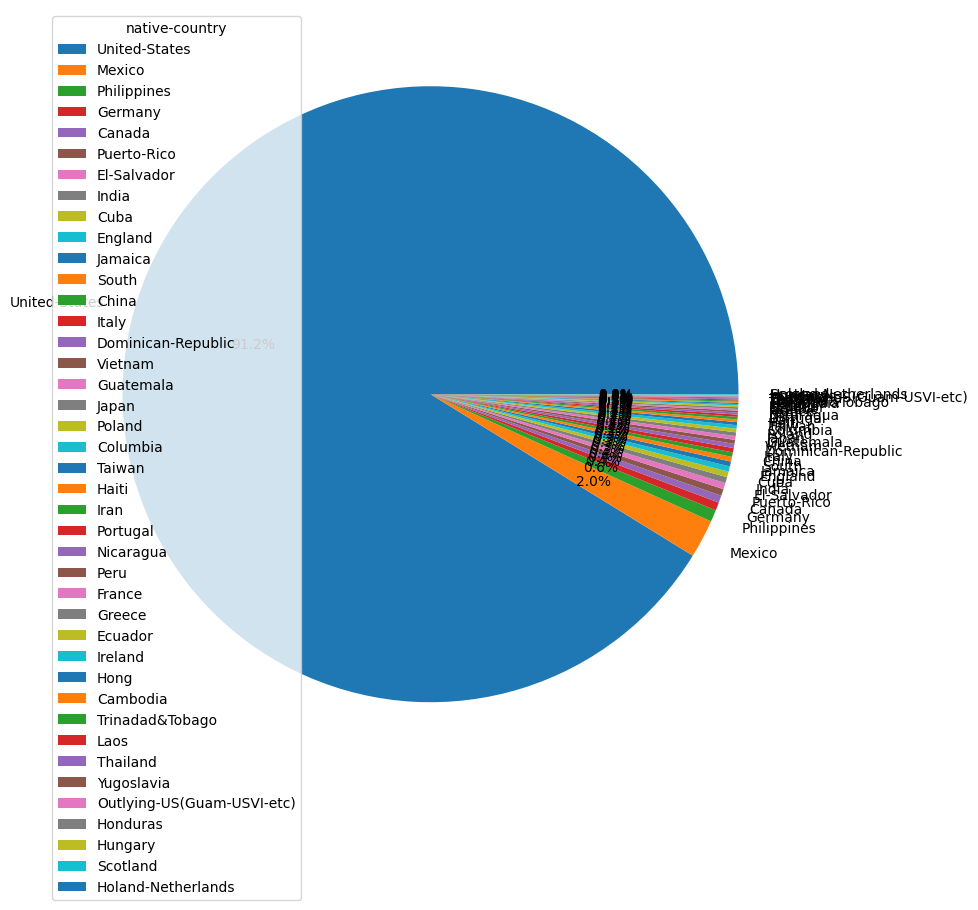

In [7]:
for col in discrete_features:
  plt.figure(figsize=(10,10))
  plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
  plt.legend(title = col)
  plt.show()

### 3. Feature Engineering
*Think about the features that could be useful for this task, are they all present in the
dataset? Anything missing? Any attribute provided that doesn’t seem useful to you?*

For the most part we don't believe there to be any missing attributes as the features feel like a comprehensive list of what could be useful for this task. The one feature we think is missing is the location of the individual as some areas are wealthier then others. It could therefore be a good indicator of income. Since, `education-num` and `education` are the same feature, we will drop `education-num` as it is more abstract and less interpretable. 

As previously mentioned, there are 3 features with missing data, `workclass`, `occupation` and `native-country`. For the first 2, we are going to make the assumption that the missing value is due to the individual not being employed, we will therefore replace the missing data with the value `Unemployed`. The `native-country` feature is a bit more complicated, but given that the majority of the dataset are United-States citizens, we will make the assumption that they are from the United-States.

In [153]:
# Drop education-num
data.drop('education-num', axis=1, inplace=True)

# Replace the values in the native-country column with `United-States`
data['native-country'].fillna('United-States', inplace=True)


# Replace missing values in workclass and occupation with 'unemployed'
data['workclass'].fillna('unemployed', inplace=True)
data['occupation'].fillna('unemployed', inplace=True)

### 4. Encode the Features
*As you will use models that need discrete or continuous attributes, think about data encoding and transformation*

We will need to encode the data in two different ways, once for Naive Bayes and once for the other two models. For both cases, we will encode the discrete features using one-hot encoding. For the continuous features however we will need to do something different. For Naive Bayes, we will use binning to discretize the continuous features. For the other two models, we will use standardization to normalize the continuous features.

#### a) Naive Bayes

For the Naive Bayes model, we will use the `Robust Scaler` to scale the continuous features. We are using this scaler as it is less sensitive to outliers then the `Standard Scaler`. We will also use the `Label Encoder` to encode the discrete features.

##### Continuous Features

In [9]:
nb_X = data.drop('income >50K', axis=1)
nb_y = data['income >50K']

In [10]:
discrete_features = [v for v in nb_X.columns if nb_X[v].dtype == 'object']
continuous_features = [v for v in nb_X.columns if nb_X[v].dtype != 'object']

## Scale the continuous features
scaler = RobustScaler()

nb_X[continuous_features] = scaler.fit_transform(nb_X[continuous_features])
nb_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1.45,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,0.0,United-States
1,0.65,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,-5.4,United-States
2,0.05,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,0.0,United-States
3,0.80,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,0.0,United-States
4,-0.45,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,0.0,Cuba


##### Discrete Features

In [11]:
enc = OneHotEncoder()

enc_feat = enc.fit_transform(nb_X[discrete_features]).toarray()
enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
enc_feat.head()

nb_X = pd.concat([nb_X[continuous_features], enc_feat], axis=1)
nb_X.head()

,age,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,1.45,2174.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.65,0.0,0.0,-5.4,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.80,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.45,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### b) Logistic Regression
For our Logistic Regression we will use the `MinMaxScaler` to normalize our continuous features and the `One Hot Encoder` to encode the discrete features.

In [12]:
lr_X = data.drop('income >50K', axis=1)
lr_y = data['income >50K']

##### Continuous Features

In [13]:
## Normalize the continuous features
from sklearn.preprocessing import MinMaxScaler

lr_X[continuous_features] = MinMaxScaler().fit_transform(lr_X[continuous_features])
lr_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.671233,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


##### Discrete Features

In [14]:
## Encode the discrete features using one hot encoding
enc = OneHotEncoder()

enc_feat = enc.fit_transform(lr_X[discrete_features]).toarray()
enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
enc_feat.head()

lr_X = pd.concat([lr_X[continuous_features], enc_feat], axis=1)
lr_X.head()

,age,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,0.671233,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### c) Multi-Layer Perceptron

In [15]:
mlp_X = lr_X
mlp_y = lr_y

### 5-7. Data Preparation, Model Training and Cross Validation

#### a) Naive Bayes

In [16]:
# Make our folds
folds = KFold(n_splits=10)
nb_scores = []
for train_index, test_index in folds.split(nb_X):
    # 5: Split the data into train and test
    nb_X_train, nb_X_test = nb_X.iloc[train_index], nb_X.iloc[test_index]
    nb_y_train, nb_y_test = nb_y.iloc[train_index], nb_y.iloc[test_index]
    
    # 6: Train the model
    gnb = GaussianNB()
    gnb.fit(nb_X_train, nb_y_train)

    # 7: Test the model
    nb_y_pred = gnb.predict(nb_X_test)
    score = accuracy_score(nb_y_test, nb_y_pred)
    print(score)
    nb_scores.append(score)

# Average score across the ten folds
print('Average Naive Bayes Score: {:.3f}'.format(np.mean(nb_scores)))

0.7909118821000921
0.7899262899262899
0.7899262899262899
0.7868550368550369
0.785012285012285
0.7886977886977887
0.7886977886977887
0.7942260442260443
0.796990171990172
0.7926904176904177
Average Naive Bayes Score: 0.790


##### Naive Bayes Score: 0.797

#### b) Logistic Regression

In [17]:
# Make our folds
folds = KFold(n_splits=10)
lr_scores = []
for train_index, test_index in folds.split(lr_X):
    # 5: Split the data into train and test
    lr_X_train, lr_X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    lr_y_train, lr_y_test = lr_y.iloc[train_index], lr_y.iloc[test_index]
    
    # 6: Train the model
    lr = LogisticRegression(solver='liblinear') # We need to use the liblinear solver due to the size of our dataset
    lr.fit(lr_X_train, lr_y_train)

    # 7: Test the model
    lr_y_pred = lr.predict(lr_X_test)
    score = accuracy_score(lr_y_test, lr_y_pred)
    print(score)
    lr_scores.append(score)
    
# Average score across the ten folds
print('Average Logistic Regression Score: {:.3f}'.format(np.mean(lr_scores)))

0.8434141848326681
0.8522727272727273
0.8544226044226044
0.839987714987715
0.8531941031941032
0.8501228501228502
0.8525798525798526
0.8538083538083538
0.8531941031941032
0.8473587223587223
Average Logistic Regression Score: 0.850


##### Logistic Regression Score: 0.85

#### c) Multi-Layer Perceptron

In [18]:
# Make our folds
folds = KFold(n_splits=10)
mlp_scores = []
for train_index, test_index in folds.split(lr_X):
    # 5: Split the data into train and test
    mlp_X_train, mlp_X_test = mlp_X.iloc[train_index], mlp_X.iloc[test_index]
    mlp_y_train, mlp_y_test = mlp_y.iloc[train_index], mlp_y.iloc[test_index]
    
    # 6: Train the model
    mlp = MLPClassifier(max_iter=1000) # We need to set max iterations to 1000 to prevent convergence warnings 
    mlp.fit(mlp_X_train, mlp_y_train)

    # 7: Test the model
    mlp_y_pred = mlp.predict(mlp_X_test)
    score = accuracy_score(mlp_y_test, mlp_y_pred)
    print(score)
    mlp_scores.append(score)
    
# Average score across the ten folds
print('Average MLP Score: {:.3f}'.format(np.mean(mlp_scores)))

0.8338962235185754
0.8372235872235873
0.8513513513513513
0.8258599508599509
0.8436732186732187
0.8427518427518428
0.8375307125307125
0.8525798525798526
0.8409090909090909
0.8363022113022113
Average MLP Score: 0.840


##### MLP Score: 0.84

### 8. Perform an evaluation with precision/recall measures

#### a) Naïve Bayes

In [72]:
nb_report = classification_report(nb_y_test, nb_y_pred, target_names=['<=50k', '>50k'])
print(nb_report)

              precision    recall  f1-score   support

       <=50k       0.93      0.78      0.85      2452
        >50k       0.55      0.83      0.66       804

    accuracy                           0.79      3256
   macro avg       0.74      0.81      0.76      3256
weighted avg       0.84      0.79      0.80      3256



#### b) Logistic Regression

In [21]:
lr_report = classification_report(lr_y_test, lr_y_pred, target_names=['<=50k', '>50k'])
print(lr_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      2452
        >50k       0.72      0.62      0.67       804

    accuracy                           0.85      3256
   macro avg       0.80      0.77      0.78      3256
weighted avg       0.84      0.85      0.84      3256



#### c) Multi-Layer Perceptron

In [23]:
mlp_report = classification_report(mlp_y_test, mlp_y_pred, target_names=['<=50k', '>50k'])
print(mlp_report)

              precision    recall  f1-score   support

       <=50k       0.89      0.90      0.89      2452
        >50k       0.67      0.65      0.66       804

    accuracy                           0.84      3256
   macro avg       0.78      0.77      0.78      3256
weighted avg       0.83      0.84      0.84      3256



### 9. For each type of model, modify some parameters and perform a train/test/evaluate again. Do this twice for each model. 

#### 9.1 Naïve Bayes

##### Run 2
GuassianNB only has two parameters, `var_smoothing` and `priors`. We will only modify `var_smoothing`. This value represents the portion of the largest variance of all features that is added to variances for calculation stability.

Training and testing the model

In [25]:
# Make our folds
from sklearn.metrics import balanced_accuracy_score


folds = KFold(n_splits=10)
nb2_scores = []
# Default value for var_smoothing is 1e-9, we will try 1e-11 to see it's effects
gnb2 = GaussianNB(var_smoothing=1e-11)
for train_index, test_index in folds.split(nb_X):
    # 5: Split the data into train and test
    nb2_X_train, nb2_X_test = nb_X.iloc[train_index], nb_X.iloc[test_index]
    nb2_y_train, nb2_y_test = nb_y.iloc[train_index], nb_y.iloc[test_index]
    
    # 6: Train the model
    gnb2.fit(nb2_X_train, nb2_y_train)

    # 7: Test the model
    nb2_y_pred = gnb2.predict(nb2_X_test)
    score = accuracy_score(nb2_y_test, nb2_y_pred)
    print(score)
    nb2_scores.append(score)

# Average score across the ten folds
print('Average Naive Bayes Score (Run 2): {:.3f}'.format(np.mean(nb2_scores)))

0.710776788455634
0.7122235872235873
0.7186732186732187
0.7066953316953317
0.7159090909090909
0.7045454545454546
0.7073095823095823
0.7328009828009828
0.7171375921375921
0.7152948402948403
Average Naive Bayes Score (Run 2): 0.714


Evaluation

In [26]:
# Classification Report
nb2_report = classification_report(nb2_y_test, nb2_y_pred, target_names=['<=50k', '>50k'])
print(nb2_report)

              precision    recall  f1-score   support

       <=50k       0.95      0.66      0.78      2452
        >50k       0.46      0.89      0.61       804

    accuracy                           0.72      3256
   macro avg       0.70      0.77      0.69      3256
weighted avg       0.83      0.72      0.73      3256



##### Run 3

Training and testing the model

In [28]:
## Make our folds
folds = KFold(n_splits=10)
nb3_scores = []
# This time we will try increasing our var_smoothing to 1e-7
gnb3 = GaussianNB(var_smoothing=1e-7)

for train_index, test_index in folds.split(nb_X):
    # 5: Split the data into train and test
    nb3_X_train, nb3_X_test = nb_X.iloc[train_index], nb_X.iloc[test_index]
    nb3_y_train, nb3_y_test = nb_y.iloc[train_index], nb_y.iloc[test_index]
    
    # 6: Train the model
    gnb3.fit(nb3_X_train, nb3_y_train)

    # 7: Test the model
    nb3_y_pred = gnb3.predict(nb3_X_test)
    score = accuracy_score(nb3_y_test, nb3_y_pred)
    print(score)
    nb3_scores.append(score)

# Average score across the ten folds
print('Average Naive Bayes Score (Run 3): {:.3f}'.format(np.mean(nb3_scores)))

0.7881486030089039
0.7994471744471745
0.7966830466830467
0.7914619164619164
0.7963759213759214
0.8040540540540541
0.7886977886977887
0.7942260442260443
0.7902334152334153
0.8006756756756757
Average Naive Bayes Score (Run 3): 0.795


Evaluation

In [29]:
nb3_report = classification_report(nb3_y_test, nb3_y_pred, target_names=['<=50k', '>50k'])
print(nb3_report)

              precision    recall  f1-score   support

       <=50k       0.81      0.95      0.88      2452
        >50k       0.70      0.34      0.46       804

    accuracy                           0.80      3256
   macro avg       0.76      0.65      0.67      3256
weighted avg       0.79      0.80      0.77      3256



##### Summary of results  

For our second run, we decreased our variable smoothing and noticed that our accuracy went down by a significant amount (from 0.77 to 0.72). We also notice in our classification report that our precision score for the positive class went down by a significant amount (from 0.54 to 0.48). This shows that increasing the variable smoothing decreases the precision of our model.

For our third run, we did the opposite. The accuracy of our model doesn't seem to have been significantly affected (from 0.77 to 0.79). However we see in our classification report that our recall score for the positive class went down by a very large amount (from 0.83 to 0.31). 

#### 9.2 Logistic Regression

##### Run 2
For our second run, we will try to change our penalty from 'l2' to 'l1'.

Training and testing the model

In [31]:
folds = KFold(n_splits=10)
lr2_scores = []
lr2 = LogisticRegression(solver='liblinear', penalty='l1')

for train_index, test_index in folds.split(lr_X):
    # 5: Split the data into train and test
    lr2_X_train, lr2_X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    lr2_y_train, lr2_y_test = lr_y.iloc[train_index], lr_y.iloc[test_index]
    
    # 6: Train the model
    lr2.fit(lr2_X_train, lr2_y_train)
    
    # 7: Test the model
    lr2_y_pred = lr2.predict(lr2_X_test)
    score = accuracy_score(lr2_y_test, lr2_y_pred)
    print(score)
    lr2_scores.append(score)

# Average score across the ten folds
print('Average Logistic Regression Score (Run 2): {:.3f}'.format(np.mean(lr2_scores)))

0.8446423088731962
0.851044226044226
0.8571867321867321
0.8390663390663391
0.8538083538083538
0.8525798525798526
0.855036855036855
0.855958230958231
0.8535012285012284
0.8498157248157249
Average Logistic Regression Score (Run 2): 0.851


Evaluation

In [32]:
# Classification Report
lr2_report = classification_report(lr2_y_test, lr2_y_pred, target_names=['<=50k', '>50k'])
print(lr2_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      2452
        >50k       0.73      0.62      0.67       804

    accuracy                           0.85      3256
   macro avg       0.81      0.77      0.79      3256
weighted avg       0.84      0.85      0.85      3256



##### Run 3

For this run, we will add inverse regularization by setting `C` to 0.2 from 1. Making C smaller increases the regularization strength.

In [34]:
folds = KFold(n_splits=10)
lr3_scores = []
lr3 = LogisticRegression(solver='liblinear', C=0.2)

for train_index, test_index in folds.split(lr_X):
    # 5: Split the data into train and test
    lr3_X_train, lr3_X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    lr3_y_train, lr3_y_test = lr_y.iloc[train_index], lr_y.iloc[test_index]
    
    # 6: Train the model
    lr3.fit(lr3_X_train, lr3_y_train)

    # 7: Test the model
    lr3_y_pred = lr3.predict(lr3_X_test)
    score = accuracy_score(lr3_y_test, lr3_y_pred)
    print(score)
    lr3_scores.append(score)

# Average score across the ten folds
print('Average Logistic Regression Score (Run 3): {:.3f}'.format(np.mean(lr3_scores)))

0.8372735646300277
0.8464373464373465
0.8495085995085995
0.8344594594594594
0.847972972972973
0.8421375921375921
0.847051597051597
0.8488943488943489
0.851044226044226
0.8418304668304668
Average Logistic Regression Score (Run 3): 0.845


Evaluation

In [35]:
# Classification Report
lr3_report = classification_report(lr3_y_test, lr3_y_pred, target_names=['<=50k', '>50k'])
print(lr3_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      2452
        >50k       0.71      0.60      0.65       804

    accuracy                           0.84      3256
   macro avg       0.79      0.76      0.78      3256
weighted avg       0.84      0.84      0.84      3256



#### 9.3 Multi-Layer Perceptron

##### Run 2

For our second Multi-layer perceptron, we will try to increase the number of hidden layers.

Training and testing the model

In [37]:
folds = KFold(n_splits=10)
mlp2_scores = []
mlp2 = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)

for train_index, test_index in folds.split(mlp_X):
    # 5: Split the data into train and test
    mlp2_X_train, mlp2_X_test = mlp_X.iloc[train_index], mlp_X.iloc[test_index]
    mlp2_y_train, mlp2_y_test = mlp_y.iloc[train_index], mlp_y.iloc[test_index]
    
    # 6: Train the model
    mlp2.fit(mlp2_X_train, mlp2_y_train)

    # 7: Test the model
    mlp2_y_pred = mlp2.predict(mlp2_X_test)
    score = accuracy_score(mlp2_y_test, mlp2_y_pred)
    print(score)
    mlp2_scores.append(score)

# Average score across the ten folds
print('Average MLP Score (Run 2): {:.3f}'.format(np.mean(mlp2_scores)))

0.8206938900828984
0.8292383292383292
0.8307739557739557
0.816031941031941
0.8298525798525799
0.831081081081081
0.8332309582309583
0.832002457002457
0.8353808353808354
0.8295454545454546
Average MLP Score (Run 2): 0.829


Evaluation

In [38]:
# Classification Report
mlp2_report = classification_report(mlp2_y_test, mlp2_y_pred, target_names=['<=50k', '>50k'])
print(mlp2_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.90      0.89      2452
        >50k       0.67      0.61      0.64       804

    accuracy                           0.83      3256
   macro avg       0.77      0.76      0.76      3256
weighted avg       0.83      0.83      0.83      3256



##### Run 3

For our final run, we will try changing the number of neurons in our hidden layer.

Training the model

In [40]:
folds = KFold(n_splits=10)
mlp3_scores = []
mlp3 = MLPClassifier(hidden_layer_sizes=(200), max_iter=1000)

for train_index, test_index in folds.split(mlp_X):
    # 5: Split the data into train and test
    mlp3_X_train, mlp3_X_test = mlp_X.iloc[train_index], mlp_X.iloc[test_index]
    mlp3_y_train, mlp3_y_test = mlp_y.iloc[train_index], mlp_y.iloc[test_index]
    
    # 6: Train the model
    mlp3.fit(mlp3_X_train, mlp3_y_train)

    # 7: Test the model
    mlp3_y_pred = mlp3.predict(mlp3_X_test)
    score = accuracy_score(mlp3_y_test, mlp3_y_pred)
    print(score)
    mlp3_scores.append(score)

# Average score across the ten folds
print('Average MLP Score (Run 3): {:.3f}'.format(np.mean(mlp3_scores)))

0.8252993552348787
0.8409090909090909
0.8482800982800983
0.8286240786240786
0.8409090909090909
0.8421375921375921
0.8341523341523341
0.8430589680589681
0.8387592137592138
0.8353808353808354
Average MLP Score (Run 3): 0.838


Evaluation

In [41]:
# Classification Report
mlp3_report = classification_report(mlp3_y_test, mlp3_y_pred, target_names=['<=50k', '>50k'])
print(mlp3_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.91      0.89      2452
        >50k       0.69      0.61      0.65       804

    accuracy                           0.84      3256
   macro avg       0.78      0.76      0.77      3256
weighted avg       0.83      0.84      0.83      3256



### 10. Analyze the obtained results

##### a) *Compare quantitatively (with the precision/recall measures) your 9 results. The 9 results come from 3 models, each with default parameters from step 6 + 2 variations from step 9.*

**Naive Bayes**  

Our Naive Bayes algorithm had the largest changes between runs of all our models. While all runs had a poor precision score for the positive class, the recall class was much more affected. The changes between our models were all in the `var-smoothing` value. Lowering the value (as in our second run) seemed to increase the recall score of the positive class, but lowers it's precision score. Increasing the value (as in our third run) had the opposite effect, with a significant drop in the recall score of the positive class but an increase in it's precision score. Overall, when looking at the averages between all three runs, we see small changes between the first 2 runs, with a much more significant change in our third. 

In [43]:
# Print our NB classification reports
print('Run 1')
print(nb_report)

print('Run 2')
print(nb2_report)

print('Run 3')
print(nb3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.93      0.78      0.85      2452
        >50k       0.55      0.83      0.66       804

    accuracy                           0.79      3256
   macro avg       0.74      0.81      0.76      3256
weighted avg       0.84      0.79      0.80      3256

Run 2
              precision    recall  f1-score   support

       <=50k       0.95      0.66      0.78      2452
        >50k       0.46      0.89      0.61       804

    accuracy                           0.72      3256
   macro avg       0.70      0.77      0.69      3256
weighted avg       0.83      0.72      0.73      3256

Run 3
              precision    recall  f1-score   support

       <=50k       0.81      0.95      0.88      2452
        >50k       0.70      0.34      0.46       804

    accuracy                           0.80      3256
   macro avg       0.76      0.65      0.67      3256
weighted avg       0.79      0.80      0.77      3256



In [44]:
print('Average NB Precision Macro Avg: {:.2f}'.format((0.74+0.71+0.78)/3 * 100))
print('Average NB Recall Macro Avg: {:.2f}'.format((0.80+0.63+0.78)/3 * 100))
print('\n')
print('Average NB Precision Weighted Avg: {:.2f}'.format((0.84+0.83+0.78)/3 * 100))
print('Average NB Recall Weighted Avg: {:.2f}'.format((0.79+0.73+0.80)/3 * 100))

Average NB Precision Macro Avg: 74.33
Average NB Recall Macro Avg: 73.67


Average NB Precision Weighted Avg: 81.67
Average NB Recall Weighted Avg: 77.33


**Logistic Regression**

Unlike the Naive Bayes model, our Logistic Regression model saw very few changes between runs. Our second run (changing the penalty from 'l2' to 'l1') had a small change to the recall score of the positive and negative class but not enough to significantly affect the averages. Our third run (changing the inverse regularization strength) had a small change to the precision score of both our classes but once again not enough to significantly affect the averages.

One thing that is interesting to note is how long it took to train the models. While run 1 and 3 took roughly the same amount of time (a few seconds), run 2 took significantly longer (over a minute). This is most likely due to the fact that the 'l1' penalty is much more computationally expensive then the 'l2' penalty.

In [45]:
# Print our LR classification reports
print('Run 1')
print(lr_report)

print('Run 2')
print(lr2_report)

print('Run 3')
print(lr3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      2452
        >50k       0.72      0.62      0.67       804

    accuracy                           0.85      3256
   macro avg       0.80      0.77      0.78      3256
weighted avg       0.84      0.85      0.84      3256

Run 2
              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      2452
        >50k       0.73      0.62      0.67       804

    accuracy                           0.85      3256
   macro avg       0.81      0.77      0.79      3256
weighted avg       0.84      0.85      0.85      3256

Run 3
              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      2452
        >50k       0.71      0.60      0.65       804

    accuracy                           0.84      3256
   macro avg       0.79      0.76      0.78      3256
weighted avg       0.84      0.84      0.84      3256



In [46]:
print('Average LR Precision Macro Avg: {:.2f}'.format((0.78+0.79+0.78)/3 * 100))
print('Average LR Recall Macro Avg: {:.2f}'.format((0.75+0.75+0.74)/3 * 100))
print('\n')
print('Average LR Precision Weighted Avg: {:.2f}'.format((0.83+0.83+0.83)/3 * 100))
print('Average LR Recall Weighted Avg: {:.2f}'.format((0.84+0.84+0.84)/3 * 100))

Average LR Precision Macro Avg: 78.33
Average LR Recall Macro Avg: 74.67


Average LR Precision Weighted Avg: 83.00
Average LR Recall Weighted Avg: 84.00


**Multi-Layer Perceptron**

Our Multi-Layer Perceptron model saw some changes between runs, but not as much as the Naive Bayes model. Our second run (increasing the number of hidden layer) slightly increased our precision score for the negative class but decreased the positive class. Our third run (increasing the number of neurons in our hidden layer) had little impact ont he precision score, but did slightly decrease the recall score of the positive class. Overall, when looking at the weighted averages between all three runs, we see very small changes between all 3

In [47]:
# Print our MLP classification reports
print('Run 1')
print(mlp_report)

print('Run 2')
print(mlp2_report)

print('Run 3')
print(mlp3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.89      0.90      0.89      2452
        >50k       0.67      0.65      0.66       804

    accuracy                           0.84      3256
   macro avg       0.78      0.77      0.78      3256
weighted avg       0.83      0.84      0.84      3256

Run 2
              precision    recall  f1-score   support

       <=50k       0.88      0.90      0.89      2452
        >50k       0.67      0.61      0.64       804

    accuracy                           0.83      3256
   macro avg       0.77      0.76      0.76      3256
weighted avg       0.83      0.83      0.83      3256

Run 3
              precision    recall  f1-score   support

       <=50k       0.88      0.91      0.89      2452
        >50k       0.69      0.61      0.65       804

    accuracy                           0.84      3256
   macro avg       0.78      0.76      0.77      3256
weighted avg       0.83      0.84      0.83      3256



In [48]:
print('Average MLP Precision Macro Avg: {:.2f}'.format((0.79+0.77+0.78)/3 * 100))
print('Average MLP Recall Macro Avg: {:.2f}'.format((0.75+0.75+0.75)/3 * 100))
print('\n')
print('Average MLP Precision Weighted Avg: {:.2f}'.format((0.83+0.83+0.83)/3 * 100))
print('Average MLP Weighted Avg: {:.2f}'.format((0.84+0.83+0.83)/3 * 100))

Average MLP Precision Macro Avg: 78.00
Average MLP Recall Macro Avg: 75.00


Average MLP Precision Weighted Avg: 83.00
Average MLP Weighted Avg: 83.33


**Comparing the three models** 

In summation, of the three models we trained, the logistic regression performed the best in terms of both recall and precision, with the multi-layer perceptron following closely behind. Naive Bayes on the other hand did significantly worse then the others, most likely due to their beings possible corelation between features in our dataset (`workclass` and `occupation` for example). As we can see in our model below, the Naive Bayes model was much more sensitive to changes in parameters then the other two models. This is made evident by the large variation in the precision and recall scores between runs.
It's interesting to note that all three models struggled with either precision or recall (or both) for the positive class. This is most likely due to the large class imbalance in our dataset. While the imbalance makes some sense from a real world perspective, it does make it difficult for our models to learn the positive class. Were we to repeat this experiment with the same dataset, we would probably want to undersample the negative class to make the dataset more balanced.

C:\Users\arahu\AppData\Local\Temp\ipykernel_20036\866258927.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


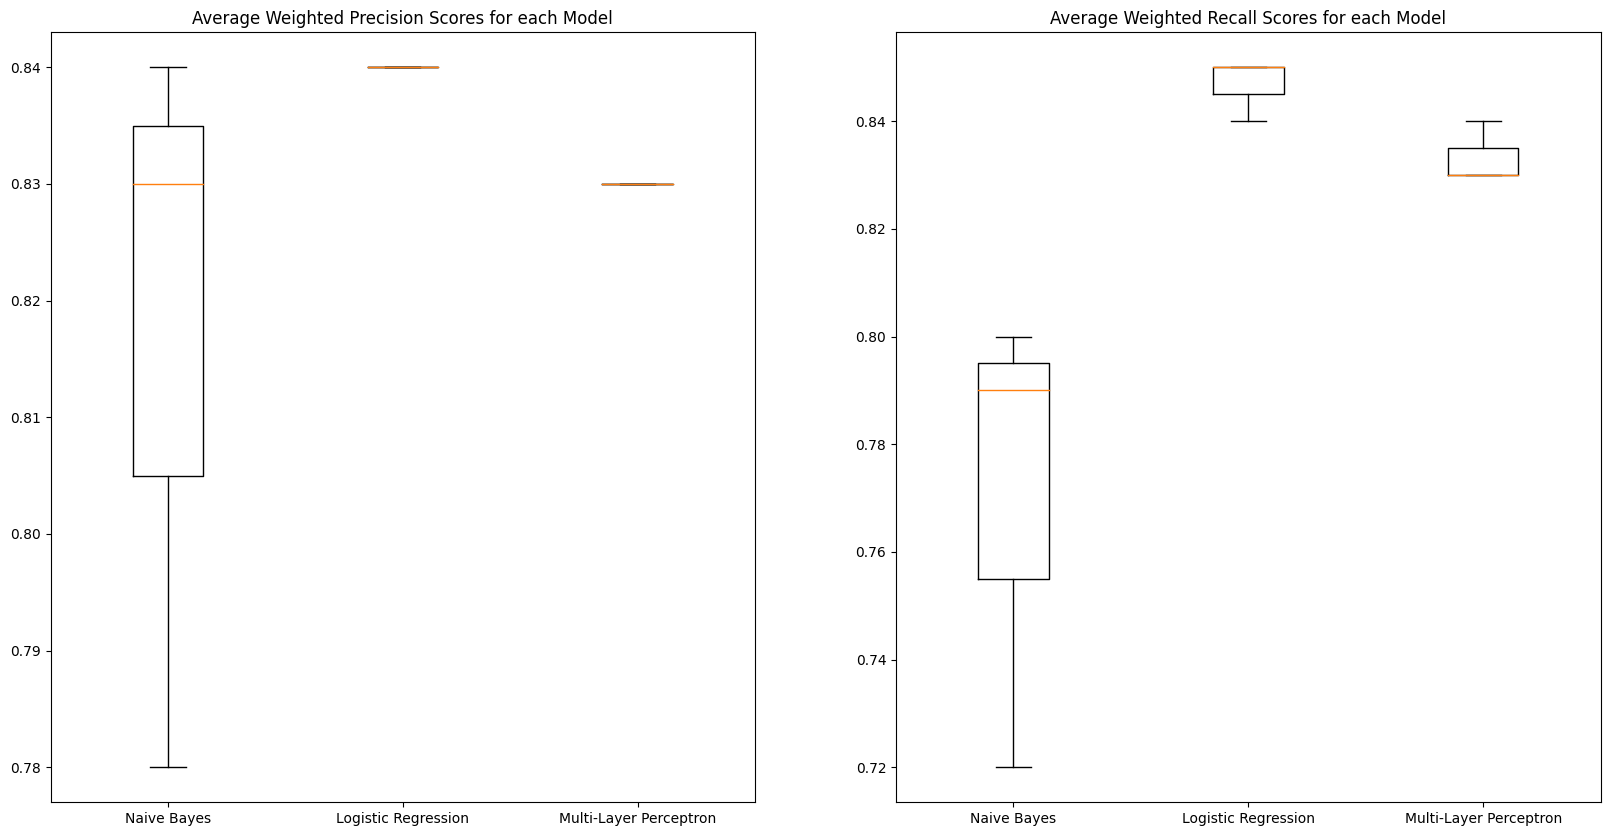

In [77]:
## Precision of the models
nb_prec = [0.84, 0.83, 0.78]
lr_prec = [0.84, 0.84, 0.84]
mlp_prec = [0.83, 0.83, 0.83]

## Recall for each model
nb_recall = [0.79, 0.72, 0.80]
lr_recall = [0.84, 0.85, 0.85]
mlp_recall = [0.84, 0.83, 0.83]

## Box models
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('Average Weighted Precision Scores for each Model')
ax[0].boxplot([nb_scores, lr_scores, mlp_scores])
ax[0].set_xticklabels(['Naive Bayes', 'Logistic Regression', 'Multi-Layer Perceptron'])

ax[1].set_title('Average Weighted Recall Scores for each Model')
ax[1].boxplot([nb_recall, lr_recall, mlp_recall])
ax[1].set_xticklabels(['Naive Bayes', 'Logistic Regression', 'Multi-Layer Perceptron'])
fig.show()

#### b) *Show some examples of results that are good and bad for each model (false positives and false negatives). Try to understand why and discuss*

<AxesSubplot: title={'center': 'Multi-Layer Perceptron'}>

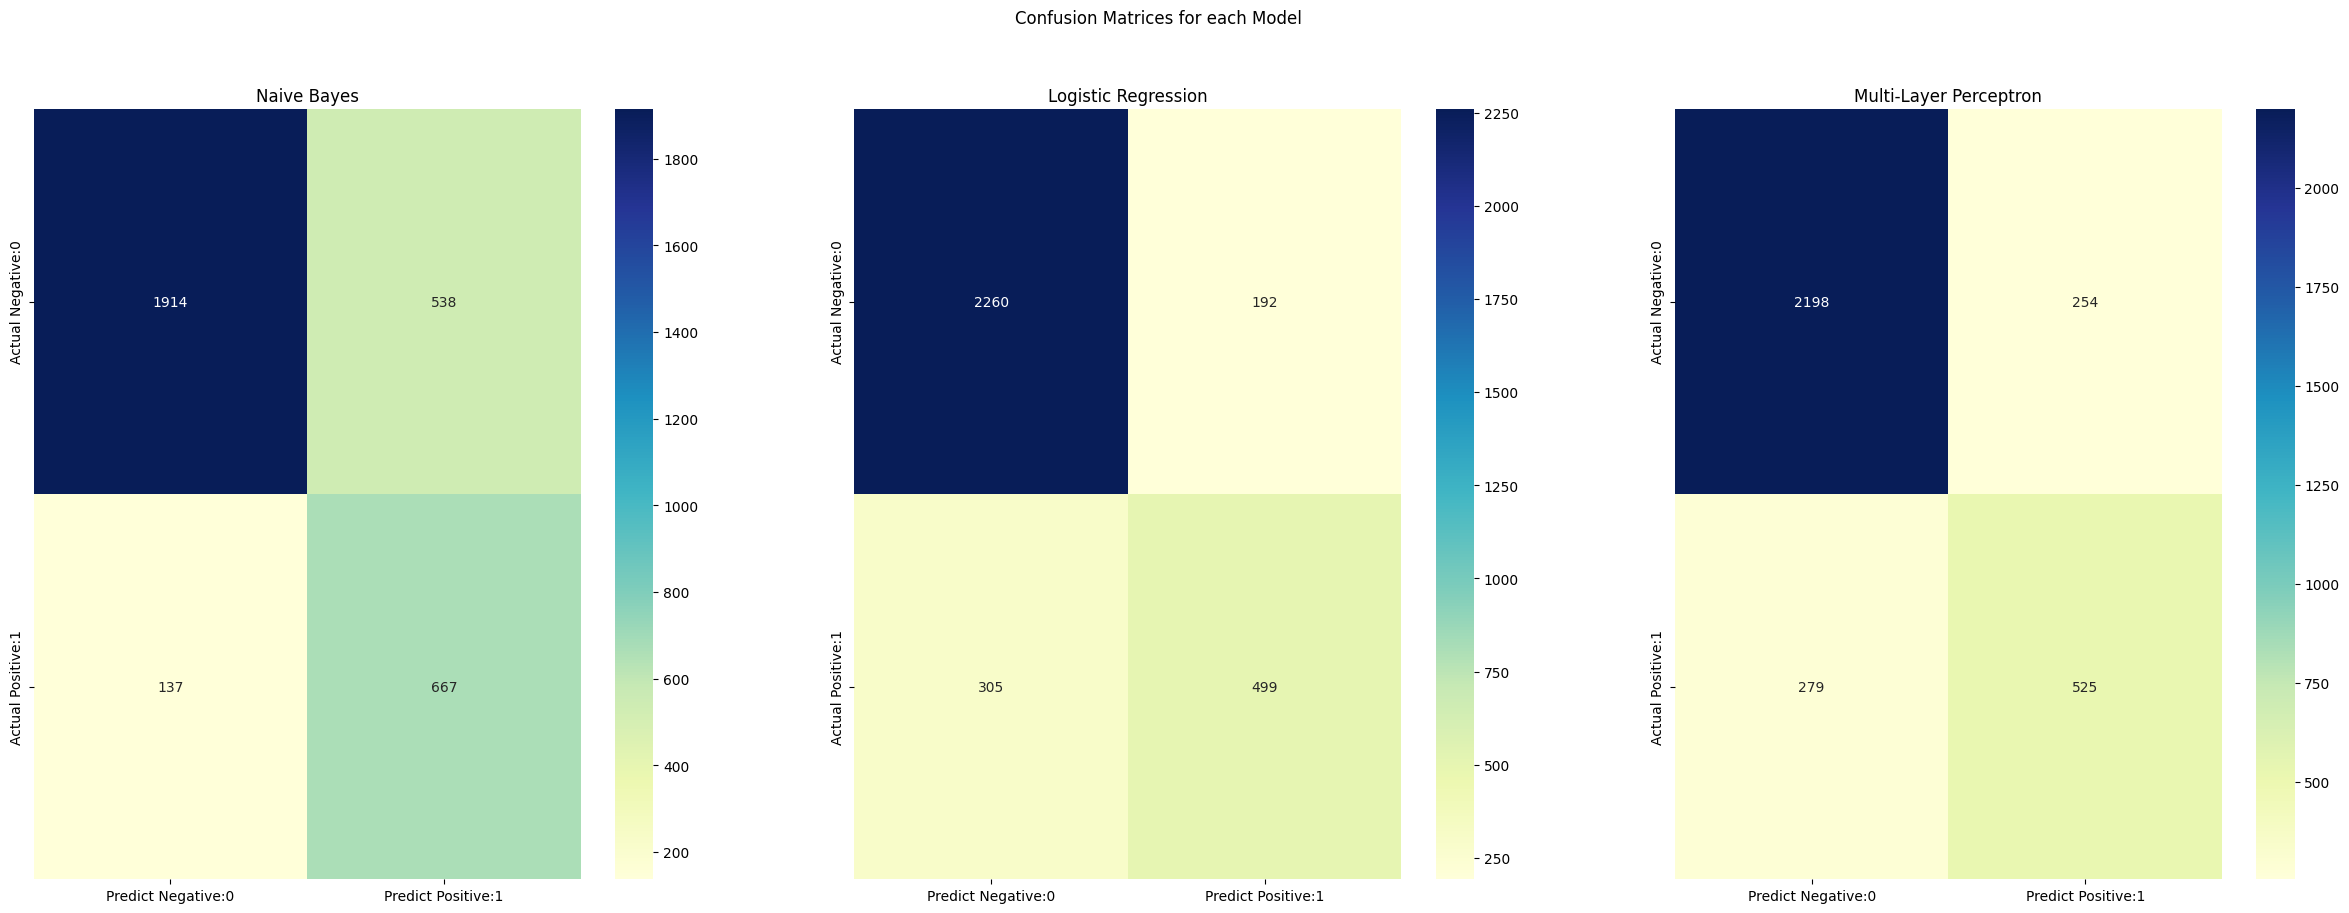

In [205]:
fig, ax = plt.subplots(1,3, figsize=(30, 10))
fig.suptitle('Confusion Matrices for each Model')

## Define the confusion matrices
nb_cm = confusion_matrix(nb_y_test, nb_y_pred, labels=[0, 1])
nb_df = pd.DataFrame(nb_cm, index=['Actual Negative:0', 'Actual Positive:1'], columns=['Predict Negative:0', 'Predict Positive:1'])

lr_cm = confusion_matrix(lr_y_test, lr_y_pred, labels=[0, 1])
lr_df = pd.DataFrame(lr_cm, index=['Actual Negative:0', 'Actual Positive:1'], columns=['Predict Negative:0', 'Predict Positive:1'])

mlp_cm = confusion_matrix(mlp_y_test, mlp_y_pred, labels=[0, 1])
mlp_df = pd.DataFrame(mlp_cm, index=['Actual Negative:0', 'Actual Positive:1'], columns=['Predict Negative:0', 'Predict Positive:1'])

## Plot the confusion matrices
ax[0].set_title('Naive Bayes')
ax[0].set_xlabel('Gold Standard')
ax[0].set_ylabel('Predicted')
sns.heatmap(nb_df, annot=True, fmt='d', cmap='YlGnBu', ax=ax[0])

ax[1].set_title('Logistic Regression')
ax[1].set_xlabel('Gold Standard')
ax[1].set_ylabel('Predicted')
sns.heatmap(lr_df, annot=True, fmt='d', cmap='YlGnBu', ax=ax[1])

ax[2].set_title('Multi-Layer Perceptron')
ax[2].set_xlabel('Gold Standard')
ax[2].set_ylabel('Predicted')
sns.heatmap(mlp_df, annot=True, fmt='d', cmap='YlGnBu', ax=ax[2])

**Naive Bayes**

Overall, our Naive Bayes model had much more false positive then false negatives. It was much more willing to predict that someone made over 50k a year when they actually didn't then the other way around.

In [279]:
## Get examples of false positives in our naive bayes model
nb_fp = nb_X_test[(nb_y_test == 0) & (nb_y_pred == 1)]
nb_fp = data.iloc[nb_fp.index]
print('False Positives')
display(nb_fp[nb_fp.education == 'HS-grad'])

nb_tp = nb_X_test[(nb_y_test == 1) & (nb_y_pred == 1)]
nb_tp = data.iloc[nb_tp.index]
print('True Positives')
display(nb_tp[nb_tp.education == 'HS-grad'])

False Positives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29327,38,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,0
29332,58,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
29379,32,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,0
29382,26,State-gov,HS-grad,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,38,United-States,0
29385,24,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434,34,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,White,Female,7443,0,35,United-States,0
32435,25,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
32444,51,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
32498,57,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0


True Positives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29316,50,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States,1
29341,53,Private,HS-grad,Divorced,Prof-specialty,Not-in-family,White,Male,4787,0,46,United-States,1
29351,69,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,12,United-States,1
29356,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,7688,0,55,United-States,1
29362,58,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32415,57,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,1
32462,48,Self-emp-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,50,United-States,1
32510,39,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,1
32518,57,Local-gov,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,99999,0,40,United-States,1


There are a wide variety of different feature classes in our false negatives which makes it difficult to determine their exact causes. That being said we believe that two classes are primarily responsible for the false negatives: `education` and `occupation`. More specifically, the model seems to have a difficult time determining if an individual with a high school education makes over 50k a year. Similarly, the models has trouble determining if an individual with an `occupation` of `Craft-repair` makes over 50k a year. Why this is the case is difficult to determine, but it may be due to most high-school graduates being younger and therefore less likely to make over 50k a year. Also, it may be that the `Craft-repair` occupation is a lower paying job and therefore less likely to make over 50k a year.

In [283]:
## Get example of false negatives in our naive bayes model
nb_fn = nb_X_test[(nb_y_test == 1) & (nb_y_pred == 0)]
nb_fn = data.iloc[nb_fn.index]
print('False Negatives')
display(nb_fn[nb_fn.workclass == 'unemployed'])

## Get our false positives
nb_tn = nb_X_test[(nb_y_test == 0) & (nb_y_pred == 0)]
nb_tn = data.iloc[nb_tn.index]
print('True Negatives')
display(nb_tn[nb_tn.workclass == 'unemployed'])

False Negatives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29421,35,unemployed,Assoc-voc,Married-civ-spouse,unemployed,Wife,White,Female,0,0,20,United-States,1
29956,68,unemployed,Some-college,Married-civ-spouse,unemployed,Wife,White,Female,0,0,12,United-States,1
30397,61,unemployed,HS-grad,Married-civ-spouse,unemployed,Husband,White,Male,0,0,38,United-States,1
31178,64,unemployed,HS-grad,Married-civ-spouse,unemployed,Husband,White,Male,0,0,50,United-States,1
31235,27,unemployed,Some-college,Married-civ-spouse,unemployed,Wife,White,Female,0,0,40,United-States,1
31390,61,unemployed,Masters,Married-civ-spouse,unemployed,Husband,White,Male,0,0,2,United-States,1
31696,90,unemployed,HS-grad,Married-civ-spouse,unemployed,Husband,White,Male,0,0,40,United-States,1
31997,60,unemployed,Some-college,Married-civ-spouse,unemployed,Husband,White,Male,0,0,12,United-States,1
31998,52,unemployed,12th,Married-civ-spouse,unemployed,Wife,Black,Female,0,0,40,United-States,1
32016,62,unemployed,HS-grad,Married-civ-spouse,unemployed,Husband,White,Male,0,0,40,United-States,1


True Negatives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29310,22,unemployed,HS-grad,Divorced,unemployed,Other-relative,Black,Female,0,0,40,United-States,0
29318,22,unemployed,Some-college,Never-married,unemployed,Own-child,White,Male,0,0,40,United-States,0
29324,67,unemployed,Masters,Widowed,unemployed,Not-in-family,White,Female,0,0,40,United-States,0
29325,20,unemployed,Some-college,Never-married,unemployed,Own-child,White,Female,0,0,15,France,0
29340,52,unemployed,7th-8th,Married-civ-spouse,unemployed,Husband,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32494,82,unemployed,HS-grad,Never-married,unemployed,Not-in-family,White,Male,0,0,3,United-States,0
32525,81,unemployed,Assoc-voc,Divorced,unemployed,Unmarried,White,Female,0,0,1,United-States,0
32531,30,unemployed,Bachelors,Never-married,unemployed,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
32541,41,unemployed,HS-grad,Separated,unemployed,Not-in-family,Black,Female,0,0,32,United-States,0


Looking at false negatives, the biggest thing that stands out to us is the fact that the model failed to correctly predict unemployed individuals with an income greater then 50 thousand. Looking at examples of such false negatives, we see that many of them are above the age of 60, which is a common retirement age. This could be a reason why the model failed to predict them correctly as they may have a pension providing them with more then 50k a year. All of this is most likely due to the fact that our model simply did not have enough such examples in our dataset, which is why it failed to learn them.

**Logistic Regression**
  
Unlike our Naive Bayes model, the logistic regression model had much fewer false negatives, but more false positives.

In [309]:
## Get examples of false positives in our logistic regression model
lr_fp = lr_X_test[(lr_y_test == 0) & (lr_y_pred == 1)]
lr_fp = data.iloc[lr_fp.index]
print('False Positives')
display(lr_fp)

## Let's also get our true positives
lr_tp = lr_X_test[(lr_y_test == 1) & (lr_y_pred == 1)]
lr_tp = data.iloc[lr_tp.index]
print('True Positives')
display(lr_tp)

False Positives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29323,46,Private,Bachelors,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,0
29327,38,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,0
29367,33,Federal-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0
29368,49,Federal-gov,Assoc-voc,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
29416,52,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,0,0,65,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32487,51,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,0
32502,35,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
32507,50,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0
32548,65,Self-emp-not-inc,Prof-school,Never-married,Prof-specialty,Not-in-family,White,Male,1086,0,60,United-States,0


True Positives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29313,45,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1
29319,27,Private,Bachelors,Never-married,Sales,Not-in-family,White,Male,13550,0,46,United-States,1
29328,60,Private,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
29351,69,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,12,United-States,1
29352,50,Self-emp-inc,Masters,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32533,54,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,50,Japan,1
32538,38,Private,Bachelors,Divorced,Prof-specialty,Unmarried,Black,Female,15020,0,45,United-States,1
32539,71,unemployed,Doctorate,Married-civ-spouse,unemployed,Husband,White,Male,0,0,10,United-States,1
32554,53,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1


Looking at our examples of false positives, we think one of the main reasons for a false positive is an individual working more hours per week, but their occupation has a lower pay. Since the model is only looking at the number of hours worked per week, it may be more likely to predict that the more an individual works, the more likely they are to make over 50k a year.

In [318]:
## Get example of false negatives in our logistic regression model
lr_fn = lr_X_test[(lr_y_test == 1) & (lr_y_pred == 0)]
lr_fn = data.iloc[lr_fn.index]
print('False Negatives')
display(lr_fn[lr_fn.occupation == 'Craft-repair'])

lr_tn = lr_X_test[(lr_y_test == 0) & (lr_y_pred == 0)]
lr_tn = data.iloc[lr_tn.index]
print('True Negatives')
display(lr_tn[lr_tn.occupation == 'Craft-repair'])

False Negatives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29316,50,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States,1
29322,60,Private,1st-4th,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Mexico,1
29392,56,Private,9th,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,1
29406,24,Private,Assoc-acdm,Separated,Craft-repair,Unmarried,Asian-Pac-Islander,Male,8614,0,40,United-States,1
29435,45,Self-emp-inc,Prof-school,Never-married,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32318,34,Private,Bachelors,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,1
32415,57,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,1
32440,30,Self-emp-not-inc,Some-college,Married-spouse-absent,Craft-repair,Own-child,White,Male,0,0,60,United-States,1
32474,36,Private,Assoc-acdm,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,52,United-States,1


True Negatives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29306,31,Self-emp-not-inc,Some-college,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,0
29311,31,Private,Bachelors,Never-married,Craft-repair,Not-in-family,Asian-Pac-Islander,Male,0,0,40,Vietnam,0
29329,20,Self-emp-not-inc,Some-college,Never-married,Craft-repair,Not-in-family,White,Female,0,0,35,United-States,0
29331,37,Private,HS-grad,Never-married,Craft-repair,Unmarried,White,Male,0,0,40,United-States,0
29332,58,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32515,66,Federal-gov,10th,Married-civ-spouse,Craft-repair,Husband,White,Male,3471,0,40,United-States,0
32517,36,Private,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
32521,33,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States,0
32537,30,Private,HS-grad,Never-married,Craft-repair,Not-in-family,Black,Male,0,0,46,United-States,0


In this case, we think that once again the occupation of `Craft-repair` is causing some difficulties for our models. Looking at the examples of false negatives, they make up nearly half of all the false negatives, despite only making up 13% of the total dataset. It is possible that there simply aren't that many examples of `Craft-repair` individuals making over 50k a year in our dataset, which is why the model failed to learn these cases.

**Multi-Layer Perceptron**


Finally, our Multi-Layer Perceptron model had a similar amount of false negatives and false positives as our logistic regression model.

In [325]:
# Get examples of false positives in our MLP model
mlp_fp = mlp_X_test[(mlp_y_test == 0) & (mlp_y_pred == 1)]
mlp_fp = data.iloc[mlp_fp.index]
print('False Positives')
display(mlp_fp[mlp_fp.occupation=='Prof-specialty'])

## Let's also get our true positives
mlp_tp = mlp_X_test[(mlp_y_test == 1) & (mlp_y_pred == 1)]
mlp_tp = data.iloc[mlp_tp.index]
print('True Positives')
display(mlp_tp[mlp_tp.occupation=='Prof-specialty'])

False Positives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29367,33,Federal-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0
29428,47,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
29505,41,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,Germany,0
29524,43,Private,Assoc-acdm,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
29534,43,State-gov,Doctorate,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32472,34,Private,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States,0
32473,41,Federal-gov,Masters,Divorced,Prof-specialty,Unmarried,White,Female,1506,0,40,United-States,0
32502,35,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
32507,50,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0


True Positives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29363,46,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024,0,60,United-States,1
29415,42,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,50,United-States,1
29460,45,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States,1
29470,35,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1
29471,37,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32466,37,Private,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024,0,45,United-States,1
32510,39,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,1
32513,46,Private,Masters,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,22,United-States,1
32532,34,Private,Doctorate,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,1


In our examples of false positives, we realized that of the 254 false positives, 71 of them had the occupation of Prof-Specialty. This is a much higher percentage then the 13% of the dataset that it makes up. This shows that the model is perhaps putting too much weight on the `Prof-Specialty` occupation.

In [337]:
# Get example of false negatives in our MLP model
mlp_fn = mlp_X_test[(mlp_y_test == 1) & (mlp_y_pred == 0)]
mlp_fn = data.iloc[mlp_fn.index]
print('False Negatives')
display(mlp_fn[mlp_fn.education == 'HS-grad'])


mlp_tn = mlp_X_test[(mlp_y_test == 0) & (mlp_y_pred == 0)]
mlp_tn = data.iloc[mlp_tn.index]
print('True Negatives')
display(mlp_tn[mlp_tn.education == 'HS-grad'])

False Negatives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29316,50,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States,1
29341,53,Private,HS-grad,Divorced,Prof-specialty,Not-in-family,White,Male,4787,0,46,United-States,1
29362,58,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States,1
29398,42,Private,HS-grad,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,1
29407,47,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,40,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32234,41,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,1
32375,59,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,1
32386,59,Federal-gov,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,1
32415,57,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,1


True Negatives


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
29305,32,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
29307,39,Private,HS-grad,Never-married,Machine-op-inspct,Not-in-family,Black,Male,0,0,40,United-States,0
29310,22,unemployed,HS-grad,Divorced,unemployed,Other-relative,Black,Female,0,0,40,United-States,0
29312,63,Private,HS-grad,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,0
29321,36,Private,HS-grad,Divorced,Adm-clerical,Unmarried,White,Female,0,0,35,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32541,41,unemployed,HS-grad,Separated,unemployed,Not-in-family,Black,Female,0,0,32,United-States,0
32542,72,unemployed,HS-grad,Married-civ-spouse,unemployed,Husband,White,Male,0,0,25,United-States,0
32547,43,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,Mexico,0
32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0


For our false negatives, we see that the model had a difficult time predicting individuals with an `education` of `HS-Grad`. This feature is part of nearly half of all false negatives, indicating that the model is most likely using it as a primary feature to determine if an individual makes over 50k a year. This is most likely due to the younger age of most individuals with 'HS-Grad' education, who are less likely to make over 50k a year.